## Introduction 
In August 2009, the Nigerian government agreed to pay amnesty to rebel and militia groups operating in the Niger-Delta Oil producing region. The Niger-Delta Amnesty Program (NDAP) aims to resolve the natural resource violence that cost the Nigerian approximately USD 23.7 billion (World Bank, 2012). This report is a data analysis of violence in the Niger-Delta region to understand how the policy impacted violence in the region. The report is an excerpt of the main research and goes through the data wrangling process, visualization and model estimation of violence before and after the amnesty policy was enacted. 

First, we load the data on violence in Nigeria. The data is retrieved from the Armed Conflict Location and Event Dataset (ACLED) in Stata .dta format. Every entry in the dataset represents a violent incidence in Nigeria. I also load a dataset that contains all the local government areas in Nigeria. I use this to match and merge the ACLED violence dataset so LGAs without any report of violence can take a value of zero. The next line shows the name of the variables in the ACLED dataset and after that I display the first five rows of the dataset. 

In [1]:
#Take out unnecessary warnings from loading packages.
options(warn=-1)

In [2]:
knitr::opts_knit$set(root.dir = '/Users/uzomailoanugo/Dropbox (Personal)/work_lodon')
#knitr::opts_knit$set(root.dir = 'C:/Users/iloan/Dropbox (Personal)/work_lodon')
knitr::opts_chunk$set(echo = TRUE)

In [2]:
#install.packages('readstata13')
#install.packages('dplyr')
#install.packages('tidyverse')
#install.packages("splitstackshape")
#install.packages(c("raster", 'rgdal', 'sp'))
#install.packages("RArchInfo")
#install.packages('lfe')
#install.packages("stargazer")
#install.packages('broom')
#install.packages('Hmisc')
#install.packages('kableExtra') 
#install.packages("ggstatsplot")

library(kableExtra)
library(Hmisc)
library(data.table)
library(readstata13)
library(dplyr)
library(tidyverse)
library(splitstackshape)
library(raster)
library(rgdal)
library(sp)
library(lfe)
library(stargazer)
library(broom)
library(xtable)
library(stringr)
library(knitr)
library(ggstatsplot)

In [4]:
con_05_16<- read.dta13("2005-01-01-2016-12-31-Nigeria.dta")
lga_id<-read.dta13("old_lga_id.dta")

In [5]:
names(con_05_16)
head(con_05_16)
head(lga_id)

[1] "data_id"          "iso"              "event_id_cnty"    "event_id_no_cnty"
 [5] "event_date"       "year"             "time_precision"   "event_type"      
 [9] "sub_event_type"   "actor1"           "assoc_actor_1"    "inter1"          
[13] "actor2"           "assoc_actor_2"    "inter2"           "interaction"     
[17] "region"           "country"          "admin1"           "admin2"          
[21] "admin3"           "location"         "latitude"         "longitude"       
[25] "geo_precision"    "source"           "source_scale"     "notes"           
[29] "fatalities"       "timestamp"        "iso3"

,data_id,iso,event_id_cnty,event_id_no_cnty,event_date,year,time_precision,event_type,sub_event_type,actor1,⋯,location,latitude,longitude,geo_precision,source,source_scale,notes,fatalities,timestamp,iso3
,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,⋯,<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>
1,6358078,566,NIG9976,9976,31-Dec-16,2016,2,Strategic developments,Arrests,Military Forces of Nigeria (2015-),⋯,Sambisa Forest Reserve,11.2500,13.4167,2,This Day (Nigeria),National,"Arrests: Security forces capture 1,400 suspects between 28 December, 2016 and 4 January, 2017 ""at the fringes of Sambisa forest.""",0,1574121968,NGA
2,6357751,566,NIG9975,9975,31-Dec-16,2016,1,Explosions/Remote violence,Suicide bomb,Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad,⋯,Maiduguri,11.8464,13.1603,1,Sun (Nigeria),National,"A suspected Boko Haram suicide bombers detonate a pack at a market late into the evening, killing herself and injuring one other.",1,1574121967,NGA
3,6358020,566,NIG9973,9973,30-Dec-16,2016,1,Battles,Armed clash,Military Forces of Nigeria (2015-),⋯,Damaturu,11.7470,11.9608,2,This Day (Nigeria),National,"On December 30, 2016 at about 1330hrs, the troops arrested a confirmed Boko Haram member at Goni Kalla. While the suspect was being moved from Goni Kalla to Damaturu, the Boko Haram member attempted to escape by jumping out of the vehicle. He was therefore shot and killed.",1,1574121968,NGA
4,6313775,566,NIG9974,9974,30-Dec-16,2016,1,Violence against civilians,Attack,Private Security Forces (Nigeria),⋯,Oku,5.0475,7.9086,1,This Day (Nigeria),National,"Sources said the armed mercenaries numbering more than 50 allegedly released by Ikot-Offiong village have in the ""past three days"" terrorised the riverine villages of Oku Iboku with 10 people feared killed, many kidnapped and more than 100 houses burnt. Other villages in the area of Oku affected by the attacks were Obot Oku, Ikot Etim Ama, Ufak Oku Iboku, Esen Ikot Esia, Esik Essien, Nta Ikan, Oku Iboku and Bokondo among other 11 coastal villages in the area.",4,1572403784,NGA
5,6357668,566,NIG9972,9972,30-Dec-16,2016,1,Battles,Armed clash,Military Forces of Nigeria (2015-),⋯,Rann,12.2829,14.4724,1,Sahara Reporters,Regional,"Boko Haram attacks military forces at Rann, leading to a three hour battle. Fifteen Boko Haram dead.",15,1574121966,NGA
6,6313392,566,NIG9971,9971,29-Dec-16,2016,1,Violence against civilians,Attack,Private Security Forces (Nigeria),⋯,Oku,5.0475,7.9086,1,This Day (Nigeria),National,"Sources said the armed mercenaries numbering more than 50 allegedly released by Ikot-Offiong village have in the ""past three days"" terrorised the riverine villages of Oku Iboku with 10 people feared killed, many kidnapped and more than 100 houses burnt. Other villages in the area of Oku affected by the attacks were Obot Oku, Ikot Etim Ama, Ufak Oku Iboku, Esen Ikot Esia, Esik Essien, Nta Ikan, Oku Iboku and Bokondo among other 11 coastal villages in the area.",3,1572403784,NGA


,state2,lgga,lga
,<chr>,<chr>,<dbl>
1,Abia,abanorth,101
2,Abia,abasouth,102
3,Abia,arochukwu,103
4,Abia,bende,104
5,Abia,ikwuano,105
6,Abia,isialangwanorth,106


  Next, I load the data set into a dplyr data frame and select only features that are important for the research. Afterwards, I generate a variable of ones for each observation reported in the dataset. The variable of ones will help identify where and when a violent event occurred - represented by 0, 1. The important features include the year the violence was recorded (year), the classification of the event (event_type), the name of violent actors (actor1, actor2), a grouping of the type of actors (inter1, inter2), the name of state and LGAs (admin1 and admin2 respectively), number of deaths reported (fatalities) and the variable of ones that represents each entry in ACLED. 

In [6]:
con_data<-tbl_df(con_05_16)
con_data<-mutate(con_data, event=1)

con_data1<-dplyr::select(con_data, year, event_type, actor1, actor2, inter1, inter2, admin1, admin2, fatalities, event)

head(con_data1)

year,event_type,actor1,actor2,inter1,inter2,admin1,admin2,fatalities,event
<int>,<chr>,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<int>,<dbl>
2016,Strategic developments,Military Forces of Nigeria (2015-),Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad,1,2,Borno,Gwoza,0,1
2016,Explosions/Remote violence,Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad,Civilians (Nigeria),2,7,Borno,Maiduguri,1,1
2016,Battles,Military Forces of Nigeria (2015-),Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad,1,2,Yobe,Damaturu,1,1
2016,Violence against civilians,Private Security Forces (Nigeria),Civilians (Nigeria),8,7,Akwa Ibom,Itu,4,1
2016,Battles,Military Forces of Nigeria (2015-),Islamic State (West Africa) and/or Boko Haram - Jamatu Ahli is-Sunnah lid-Dawatai wal-Jihad,1,2,Borno,Kala/Balge,15,1
2016,Violence against civilians,Private Security Forces (Nigeria),Civilians (Nigeria),8,7,Akwa Ibom,Itu,3,1


I also generate variables to identify and represent the different classification of violence in the ACLED dataset. These variables include battle involving government forces (Battle), violence against civilians (VAC), protests (Protests) and Violence that involved rebel, ethnic and political militias (Rebel).

In [7]:
con_data1<-mutate(con_data1, Battles=0, VAC=0, Protests=0, Rebel=0, Fata_rebel=0)

con_data1$Battles[con_data1$event_type=="Battles"]<-1 
con_data1$Protests<-with(con_data1, ifelse(event_type=="Protests", 1, Protests))
con_data1$VAC<-with(con_data1, ifelse(event_type=="Violence against civilians", 1, VAC))
con_data1$Rebel[con_data1$inter1==2 | con_data1$inter1==3 | con_data1$inter1==4]<-1
con_data1$Rebel[con_data1$inter2==2 | con_data1$inter2==3 | con_data1$inter2==4]<-1
con_data1$Fata_rebel[con_data1$Rebel==1]<-con_data1$fatalities[con_data1$Rebel==1]

I group the dataset by admin1 (State), admin2(LGA), year.

In [8]:
con_data1<-dplyr::select(con_data1, year, admin1, admin2, Fata_rebel, fatalities, event, Battles, VAC, Protests, Rebel)
con_data1<-group_by(con_data1, admin1, admin2, year)
head(con_data1)

year,admin1,admin2,Fata_rebel,fatalities,event,Battles,VAC,Protests,Rebel
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2016,Borno,Gwoza,0,0,1,0,0,0,1
2016,Borno,Maiduguri,1,1,1,0,0,0,1
2016,Yobe,Damaturu,1,1,1,1,0,0,1
2016,Akwa Ibom,Itu,0,4,1,0,1,0,0
2016,Borno,Kala/Balge,15,15,1,1,0,0,1
2016,Akwa Ibom,Itu,0,3,1,0,1,0,0


Based on the grouping variables, I sum the number of all classes of incidence.

In [9]:
con_ev_data<-summarise_at(con_data1, vars(Fata_rebel, fatalities, event, Battles, VAC, Protests, Rebel), 
             funs(sum(., na.rm=T)))
head(con_ev_data)

admin1,admin2,year,Fata_rebel,fatalities,event,Battles,VAC,Protests,Rebel
<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abia,Aba South,2005,0,0,2,0,1,1,1
Abia,Aba South,2008,3,3,1,1,0,0,1
Abia,Aba South,2009,10,10,3,2,0,1,2
Abia,Aba South,2010,5,5,6,2,4,0,6
Abia,Aba South,2013,2,2,2,1,0,1,1
Abia,Aba South,2014,0,0,2,0,1,0,2


Next, I prepare the dataset to merge with the list of all LGAs in Nigeria. 

In [10]:
con_ev_data$admin2<-tolower(con_ev_data$admin2)
con_ev_data$admin2<-gsub(" ", "", con_ev_data$admin2)
con_ev_data$admin2<-gsub("-", "", con_ev_data$admin2)
con_ev_data$admin2<-gsub("/", "", con_ev_data$admin2)
names(con_ev_data)[names(con_ev_data)=="admin1"]<-"state"
names(con_ev_data)[names(con_ev_data)=="admin2"]<-"lgga"

head(con_ev_data)

state,lgga,year,Fata_rebel,fatalities,event,Battles,VAC,Protests,Rebel
<chr>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Abia,abasouth,2005,0,0,2,0,1,1,1
Abia,abasouth,2008,3,3,1,1,0,0,1
Abia,abasouth,2009,10,10,3,2,0,1,2
Abia,abasouth,2010,5,5,6,2,4,0,6
Abia,abasouth,2013,2,2,2,1,0,1,1
Abia,abasouth,2014,0,0,2,0,1,0,2


To ensure the two datasets merge correctly, I make sure the merge variables of state and LGAs are identical in the both dataset. I created a variable that returns "FALSE" when observations are not found in both dataset. With the TRUE/FALSE variable, I identify which naming of State and LGAs to change. 

In [11]:
id_in_con<-unique(con_ev_data[c("state", "lgga")])
id_in_con$rename_lgga<-!id_in_con$lgga %in% lga_id$lgga
rename_lga<-filter(id_in_con, rename_lgga==TRUE)

head(rename_lga)

state,lgga,rename_lgga
<chr>,<chr>,<lgl>
Abia,isiukwuato,TRUE
Abia,osisiomangwa,TRUE
Adamawa,fufore,TRUE
Adamawa,girei,TRUE
Bauchi,jama'are,TRUE
Bayelsa,yenegoa,TRUE


In [12]:
con_ev_data$lgga[con_ev_data$lgga=="isiukwuato"]<-"isuikwuato"
con_ev_data$lgga<-gsub("osisiomangwa", "osisioma", con_ev_data$lgga)
con_ev_data$lgga<-gsub("fufore", "fufure", con_ev_data$lgga)
con_ev_data$lgga<-gsub("girei", "grie", con_ev_data$lgga)
con_ev_data$lgga<-gsub("jama'are", "jamaare", con_ev_data$lgga)
con_ev_data$lgga<-gsub("yenegoa", "yenagoa", con_ev_data$lgga)
con_ev_data$lgga<-gsub("bekwara", "bekwarra", con_ev_data$lgga)
con_ev_data$lgga<-gsub("yakurr", "yakuur", con_ev_data$lgga)
con_ev_data$lgga<-gsub("aiyekire(gbonyin)", "gbonyin", con_ev_data$lgga)
con_ev_data$lgga[con_ev_data$lgga=="aiyekire(gbonyin)"]<-"gbonyin"
con_ev_data$lgga<-gsub("abujamunicipal", "municipalareacouncil", con_ev_data$lgga)
con_ev_data$lgga<-gsub("birnikudu", "birninkudu", con_ev_data$lgga)
con_ev_data$lgga<-gsub("jema'a", "jemaa", con_ev_data$lgga)
con_ev_data$lgga<-gsub("markafi", "makarfi", con_ev_data$lgga)
con_ev_data$lgga<-gsub("zangokataf", "zangonkataf", con_ev_data$lgga)
con_ev_data$lgga<-gsub("garummallam", "garunmallam", con_ev_data$lgga)
con_ev_data$lgga<-gsub("olamabolo", "olamaboro", con_ev_data$lgga)
con_ev_data$lgga<-gsub("ifakoijaye", "ifakoijaiye", con_ev_data$lgga)
con_ev_data$lgga<-gsub("nasarawaeggon", "nasarawaegon", con_ev_data$lgga)
con_ev_data$lgga<-gsub("aiyedade", "aiyedaade", con_ev_data$lgga)
con_ev_data$lgga<-gsub("atakumosaeast", "atakunmosaeast", con_ev_data$lgga)
con_ev_data$lgga<-gsub("ileshaeast", "ilesaeast", con_ev_data$lgga)
con_ev_data$lgga<-gsub("oyowest", "oyo", con_ev_data$lgga)
con_ev_data$lgga<-gsub("emohua", "emuoha", con_ev_data$lgga)
con_ev_data$lgga<-gsub("obiaakpor", "obioakpor", con_ev_data$lgga)
con_ev_data$lgga<-gsub("karinlamido", "karimlamido", con_ev_data$lgga)
con_ev_data$lgga<-gsub("kurmi", "kumi", con_ev_data$lgga)
con_ev_data$lgga<-gsub("tarmua", "tarmuwa", con_ev_data$lgga)
con_ev_data$lgga<-gsub("birninmagaji", "birninmagajikiyaw", con_ev_data$lgga)
con_ev_data$lgga<-gsub("tsafe", "chafe", con_ev_data$lgga)



I re-run the test and now both state and LGA variable are identical in both datasets. 

In [13]:
id_in_con2<-unique(con_ev_data[c("state", "lgga")])
id_in_con2$rename_lgga<-!id_in_con2$lgga %in% lga_id$lgga
filter(id_in_con2, rename_lgga==TRUE)

state,lgga,rename_lgga
<chr>,<chr>,<lgl>


For the data analysis, I will need data from 2005 to 2016 year time period that contains almost the same number of observations before and after the amnesty policy was enacted. I create a dplyr dataframe of the LGAs and expand the data of 774 LGAs over 9 year period giving a total of 9288 observations. 

In [14]:
nig_lgga<-tbl_df(lga_id)
nig_lgga<-expandRows(nig_lgga, 12, count.is.col = F)
nig_lgga<-group_by(nig_lgga, state2, lgga)
names(nig_lgga)[names(nig_lgga)=='state2'] <- 'state'

nig_lgga<-mutate(nig_lgga, year=(seq("2005", "2016", 1)))
dim(nig_lgga)

[1] 9288    4

The ACLED event dataset and the dataset representing all LGAs and state in Nigeria are merged. The observations in the merged dataset that have NA are those observations where there are no record of violence recorded by ACLED in the time period covered in the research. 

In [15]:
####MERGING THE TWO DATASETS ###########
con_main<-merge(nig_lgga, con_ev_data, by=c("lgga", "year"), all.x = T)
head(con_main)

,lgga,year,state.x,lga,state.y,Fata_rebel,fatalities,event,Battles,VAC,Protests,Rebel
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,abadam,2005,Borno,801,NA,NA,NA,NA,NA,NA,NA,NA
2,abadam,2006,Borno,801,NA,NA,NA,NA,NA,NA,NA,NA
3,abadam,2007,Borno,801,NA,NA,NA,NA,NA,NA,NA,NA
4,abadam,2008,Borno,801,NA,NA,NA,NA,NA,NA,NA,NA
5,abadam,2009,Borno,801,NA,NA,NA,NA,NA,NA,NA,NA
6,abadam,2010,Borno,801,NA,NA,NA,NA,NA,NA,NA,NA


Next, I replace NAs with zero values, create a variable that accounts for the years the amnesty policy was active (amnes_yr), and an indicator variable that identify Niger-Delta states in Nigeria.

In [16]:
con_main[is.na(con_main)]<-0
con_main$amnes_yr<-0
con_main$amnes_yr[con_main$year>=2010]<-1
con_main$niger_del_all<-0
con_main$niger_del_all[con_main$state.x=="Akwa" | con_main$state.x=="Bayelsa" 
                   | con_main$state.x=="Edo" | con_main$state.x=="Rivers"
                   | con_main$state.x=="Abia" | con_main$state.x=="Imo"
                   | con_main$state.x=="Cross" | con_main$state.x=="Delta"
                   | con_main$state.x=="Ondo"]<-1
names(con_main)
head(con_main)

[1] "lgga"          "year"          "state.x"       "lga"          
 [5] "state.y"       "Fata_rebel"    "fatalities"    "event"        
 [9] "Battles"       "VAC"           "Protests"      "Rebel"        
[13] "amnes_yr"      "niger_del_all"

,lgga,year,state.x,lga,state.y,Fata_rebel,fatalities,event,Battles,VAC,Protests,Rebel,amnes_yr,niger_del_all
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,abadam,2005,Borno,801,0,0,0,0,0,0,0,0,0,0
2,abadam,2006,Borno,801,0,0,0,0,0,0,0,0,0,0
3,abadam,2007,Borno,801,0,0,0,0,0,0,0,0,0,0
4,abadam,2008,Borno,801,0,0,0,0,0,0,0,0,0,0
5,abadam,2009,Borno,801,0,0,0,0,0,0,0,0,0,0
6,abadam,2010,Borno,801,0,0,0,0,0,0,0,0,1,0


Because I am interesting in the probability of having a violent event before and after the amnesty policy, I generate dummy varaibles that take a value of 1 if there was a reported incidence of violence by ACLED. 

In [17]:
con_main$prob_rebel<-0
con_main$prob_rebel[con_main$Rebel>0]<-1

con_main$prob_Battles<-0
con_main$prob_Battles[con_main$Battles>0]<-1

con_main$prob_VAC<-0
con_main$prob_VAC[con_main$VAC>0]<-1

con_main$prob_event<-0
con_main$prob_event[con_main$event>0]<-1

con_main$prob_fatalities<-0
con_main$prob_fatalities[con_main$fatalities>0]<-1

con_main$prob_protest<-0
con_main$prob_protest[con_main$Protests>0]<-1

con_main$prob_Fata_rebel<-0
con_main$prob_Fata_rebel[con_main$Fata_rebel>0]<-1

names(con_main)
tail(con_main[c("lgga", "year", "prob_rebel", "prob_Battles", "prob_VAC", "prob_fatalities", "prob_protest", 'prob_Fata_rebel')])

[1] "lgga"            "year"            "state.x"         "lga"            
 [5] "state.y"         "Fata_rebel"      "fatalities"      "event"          
 [9] "Battles"         "VAC"             "Protests"        "Rebel"          
[13] "amnes_yr"        "niger_del_all"   "prob_rebel"      "prob_Battles"   
[17] "prob_VAC"        "prob_event"      "prob_fatalities" "prob_protest"   
[21] "prob_Fata_rebel"

,lgga,year,prob_rebel,prob_Battles,prob_VAC,prob_fatalities,prob_protest,prob_Fata_rebel
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9287,zuru,2011,0,0,0,0,0,0
9288,zuru,2012,0,0,0,0,0,0
9289,zuru,2013,0,0,0,0,0,0
9290,zuru,2014,0,1,0,1,0,0
9291,zuru,2015,0,0,0,0,0,0
9292,zuru,2016,1,1,0,1,0,1


The next step will be to specifically identify LGAs with oil fields in teh Nigeria. To do this, I use a dataset retrieved by Koos and Pierskalla (2016) complied by GIS solutions Nigeria. 

In [18]:
koos_oil_data<-read.dta13("oil_koos_2.dta")
names(koos_oil_data)
head(koos_oil_data)

[1] "state"           "lgaa"            "flare_count"     "oilf_count"     
 [5] "electricity_pct" "ethnic_n"        "allocpc"         "pipearea"       
 [9] "state2"          "lgga"            "lga"

,state,lgaa,flare_count,oilf_count,electricity_pct,ethnic_n,allocpc,pipearea,state2,lgga,lga
,<fct>,<fct>,<int>,<int>,<fct>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<fct>
1,Abia,Aba North,0,0,75%,1,0.01773979,0.148888886,Abia,abanorth,abanorth
2,Abia,Aba South,0,0,71%,1,0.00953947,0.228431374,Abia,abasouth,abasouth
3,Abia,Arochukw,0,0,26%,2,0.01407655,0.000000000,Abia,arochukwu,arochukwu
4,Abia,Bende,0,0,7%,2,0.01313669,0.007298188,Abia,bende,bende
5,Abia,Ikwuano,0,0,22%,1,0.01650660,0.000000000,Abia,ikwuano,ikwuano
6,Abia,Isiala Ngwa North,0,0,37%,2,0.01548092,0.041607842,Abia,isialangwanorth,isialangwanorth


I merge the oil field location dataset with the main violence dataset using LGA names availble in both dataset. I generate a dummy variable for the presence of oil field across LGAs in Nigeria. 

In [19]:
con_main<-merge(con_main, koos_oil_data, by="lgga", all.x = T)
con_main<-dplyr::select(con_main, -c("lga.x", "state.y", "lgaa", "state", "lga.y"))

con_main$niger_del_oilf <- 0
con_main$niger_del_oilf[con_main$oilf_count>0 & con_main$niger_del_all==1] <- 1
names(con_main)

[1] "lgga"            "year"            "state.x"         "Fata_rebel"     
 [5] "fatalities"      "event"           "Battles"         "VAC"            
 [9] "Protests"        "Rebel"           "amnes_yr"        "niger_del_all"  
[13] "prob_rebel"      "prob_Battles"    "prob_VAC"        "prob_event"     
[17] "prob_fatalities" "prob_protest"    "prob_Fata_rebel" "flare_count"    
[21] "oilf_count"      "electricity_pct" "ethnic_n"        "allocpc"        
[25] "pipearea"        "state2"          "niger_del_oilf"

In [20]:
kable_styling(kable(table(dplyr::select(con_main[con_main$year==2010,], "niger_del_all", "niger_del_oilf")))) %>%
  add_header_above(c(" ", "Oil Field" = 2)) %>%
  pack_rows("Niger-Delta", 1, 2)

<table class="table" style="margin-left: auto; margin-right: auto;">
 <thead>
<tr>
<th style="border-bottom:hidden" colspan="1"></th>
<th style="border-bottom:hidden; padding-bottom:0; padding-left:3px;padding-right:3px;text-align: center; " colspan="2"><div style="border-bottom: 1px solid #ddd; padding-bottom: 5px; ">Oil Field</div></th>
</tr>
  <tr>
   <th style="text-align:left;">   </th>
   <th style="text-align:right;"> 0 </th>
   <th style="text-align:right;"> 1 </th>
  </tr>
 </thead>
<tbody>
  <tr grouplength="2"><td colspan="3" style="border-bottom: 1px solid;"><strong>Niger-Delta</strong></td></tr>
<tr>
   <td style="text-align:left; padding-left: 2em;" indentlevel="1"> 0 </td>
   <td style="text-align:right;"> 589 </td>
   <td style="text-align:right;"> 0 </td>
  </tr>
  <tr>
   <td style="text-align:left; padding-left: 2em;" indentlevel="1"> 1 </td>
   <td style="text-align:right;"> 124 </td>
   <td style="text-align:right;"> 61 </td>
  </tr>
</tbody>
</table>

The table above shows that of 774 LGAs, none of the LGAs located outside Niger-Delta have an oil field. All 55 LGAs with oil fields are located within the oil rich Niger-Delta region.  

# Mapping Niger-Delta Region in Nigeria.
This research aims to understand how the amnesty policy changed impacted the incidence of violence in the oil producing region in Nigeria. In order to understand what local government areas we are comparing with oil producing Local government areas (LGAs), I will create a map of Nigeria representing LGAs in Niger-Delta with and without oil fields.  

Firstly, I will load in a shape file that forms the base for the map in R using Rgdal package.

OGR data source with driver: ESRI Shapefile 
Source: "/Users/uzomailoanugo/Desktop/git_folder/Amnesty-Policy/nga_adm", layer: "nga_admbnda_adm2_osgof_20170222"
with 774 features
It has 14 fields


[1] "Abia"                      "Abia"                     
[3] "Federal Capital Territory" "Akwa Ibom"                
[5] "Ebonyi"                    "Ogun"

[1] "Abia"    "Abia"    "Federal" "Akwa"    "Ebonyi"  "Ogun"

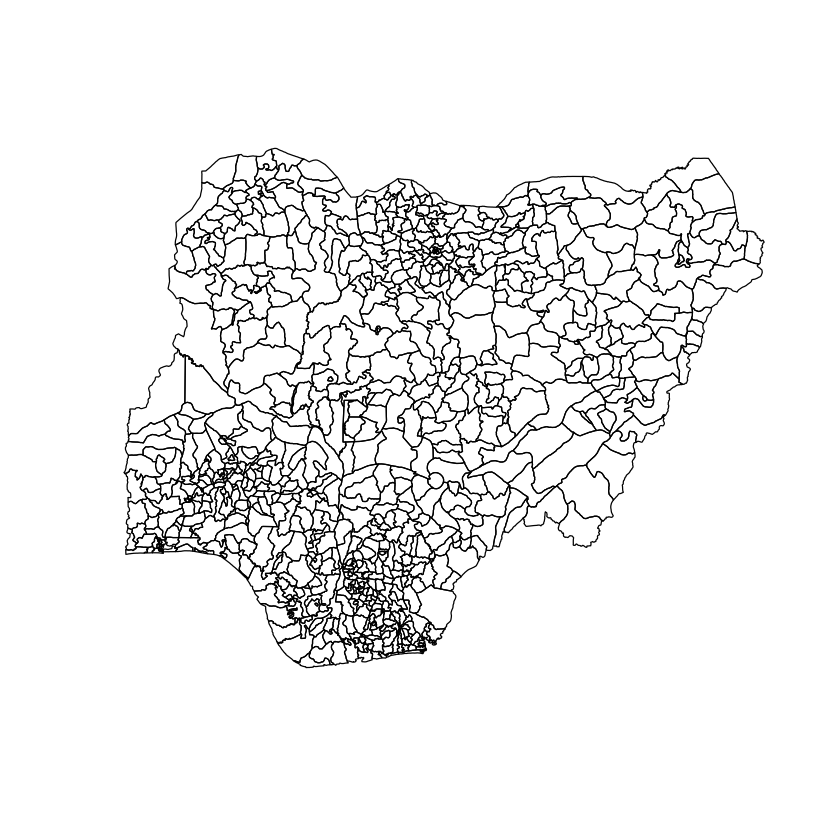

In [21]:
nig_lga4<-readOGR(dsn ="nga_adm", 
                  layer="nga_admbnda_adm2_osgof_20170222")

plot(nig_lga4)
head(nig_lga4$admin1Name)
nig_lga4$admin1Name <- word(nig_lga4$admin1Name, 1)
head(nig_lga4$admin1Name)

In order to assign colour attributes that distinguish between LGAs in Niger-Delta from all other parts of Nigeria, I assign numbers to LGAs. Number 1 will represent all other parts of Nigeria while '2' will be assigned LGAs in Niger-Delta. 

In [22]:
nig_lga4@data$Col <- 1

nig_lga4$Col[nig_lga4$admin1Name=="Abia"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Akwa"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Bayelsa"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Cross"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Delta"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Edo"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Imo"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Ondo"] <- 2
nig_lga4$Col[nig_lga4$admin1Name=="Rivers"] <- 2

  Next, I will bring in the data I intend to use for the analysis. The Koos and Pierskalla (2016) data identifies which LGAs in the Niger-Delta have oil fields. I will need this data to know which LGAs on the shape file to assigne  a colour that indicates the presence of oil fields (red colour in this case). 

In [23]:
oil_lga1 <- unique(dplyr::select(con_main, "lgga", "state.x", "niger_del_oilf")) # I need only LGAs, State and oil field location. 
oil_lga1 <- arrange(oil_lga1, state.x, lgga)
rownames(oil_lga1) <- 1:nrow(oil_lga1)
names(oil_lga1)[names(oil_lga1)=="lgga"]<- "admin2Name" 


# A major part of this code is to ensure the LGA and State names on the dataset matches what is on the shape file. 
nig_lga4$admin2Name <- tolower(nig_lga4$admin2Name) 
nig_lga4$admin2Name <- gsub("-", "", nig_lga4$admin2Name)
nig_lga4$admin2Name <- gsub("/", "", nig_lga4$admin2Name)
nig_lga4$admin2Name <- gsub(" ", "", nig_lga4$admin2Name)

new_oil <-oil_lga1[oil_lga1$niger_del_oilf==1,] # subset and assign data that have oil field into a new set. 
new_oil <- dplyr::tbl_df(new_oil)
new_oil <- dplyr::select(new_oil, admin2Name)

nig_lga4@data$oilf <- NA # Create a new attribute that will hold the colour assignment on the shape file. 

# This loop assigns an integer (2) into the specific LGAs that have oil fields. 
for (i in new_oil$admin2Name) {
        nig_lga4$oilf[nig_lga4$admin2Name== i] <- 2  
}

oilf_col <- c(0,"brown")[nig_lga4$oilf] # I assign the colour brown to indicate oil fields
nd_colour <- c("white","grey50")[nig_lga4$Col] # I assign the colour grey to indicate the Niger-Delta region. 

I plot the maps, assigning colour that represents Non-Niger Delta, Niger-Delta without oil fields and Niger-Delta with oil fields. 

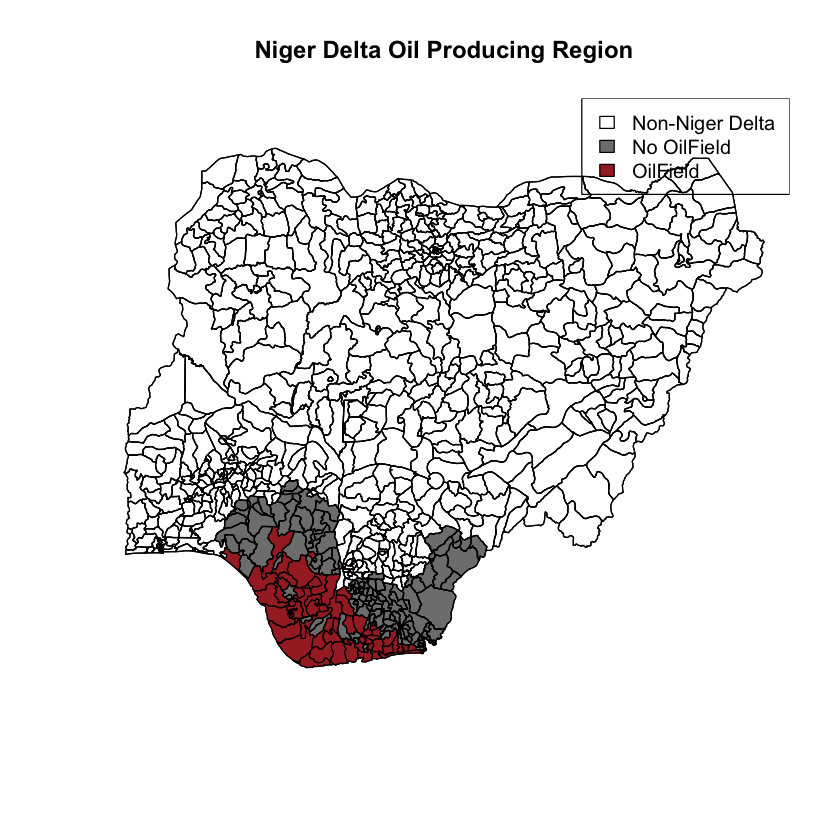

In [24]:
plot(nig_lga4,
     col=nd_colour, main="Niger Delta Oil Producing Region")

plot(nig_lga4,
     col=nd_colour, main="Niger Delta Oil Producing Region")
plot(nig_lga4,
     col=oilf_col, add = T)
legend("topright", legend = c("Non-Niger Delta", "No OilField", "OilField"), 
       fill = c('white', 'grey50', 'brown'))

  The map allows us to have a visual representation of Nigeria with the different types of LGAs. The coloured (Grey and Brown) area is the Niger-Delta region. The brown region are LGAs with oil fields in Nigeria. The research aims to compare the incidence of rebel and militia violence between Niger-Delta LGAs with and without oil fields before and after the amnesty policy was enacted.  
  
  Before we go into the parametric model for the estimation, it will be a good idea to see the trend in unconditional mean of rebel/militia events in the data. I create a subset of the of events in the Niger-Delta and transform the oil field dummy variable as factor to aid in plotting. 

In [25]:
con_mean<-con_main[con_main$niger_del_all==1 & con_main$year>2005,]
con_mean$niger_del_oilf<-as.factor(con_mean$niger_del_oilf)

The plot of unconditional means of rebel/militia event using ggplot2. 

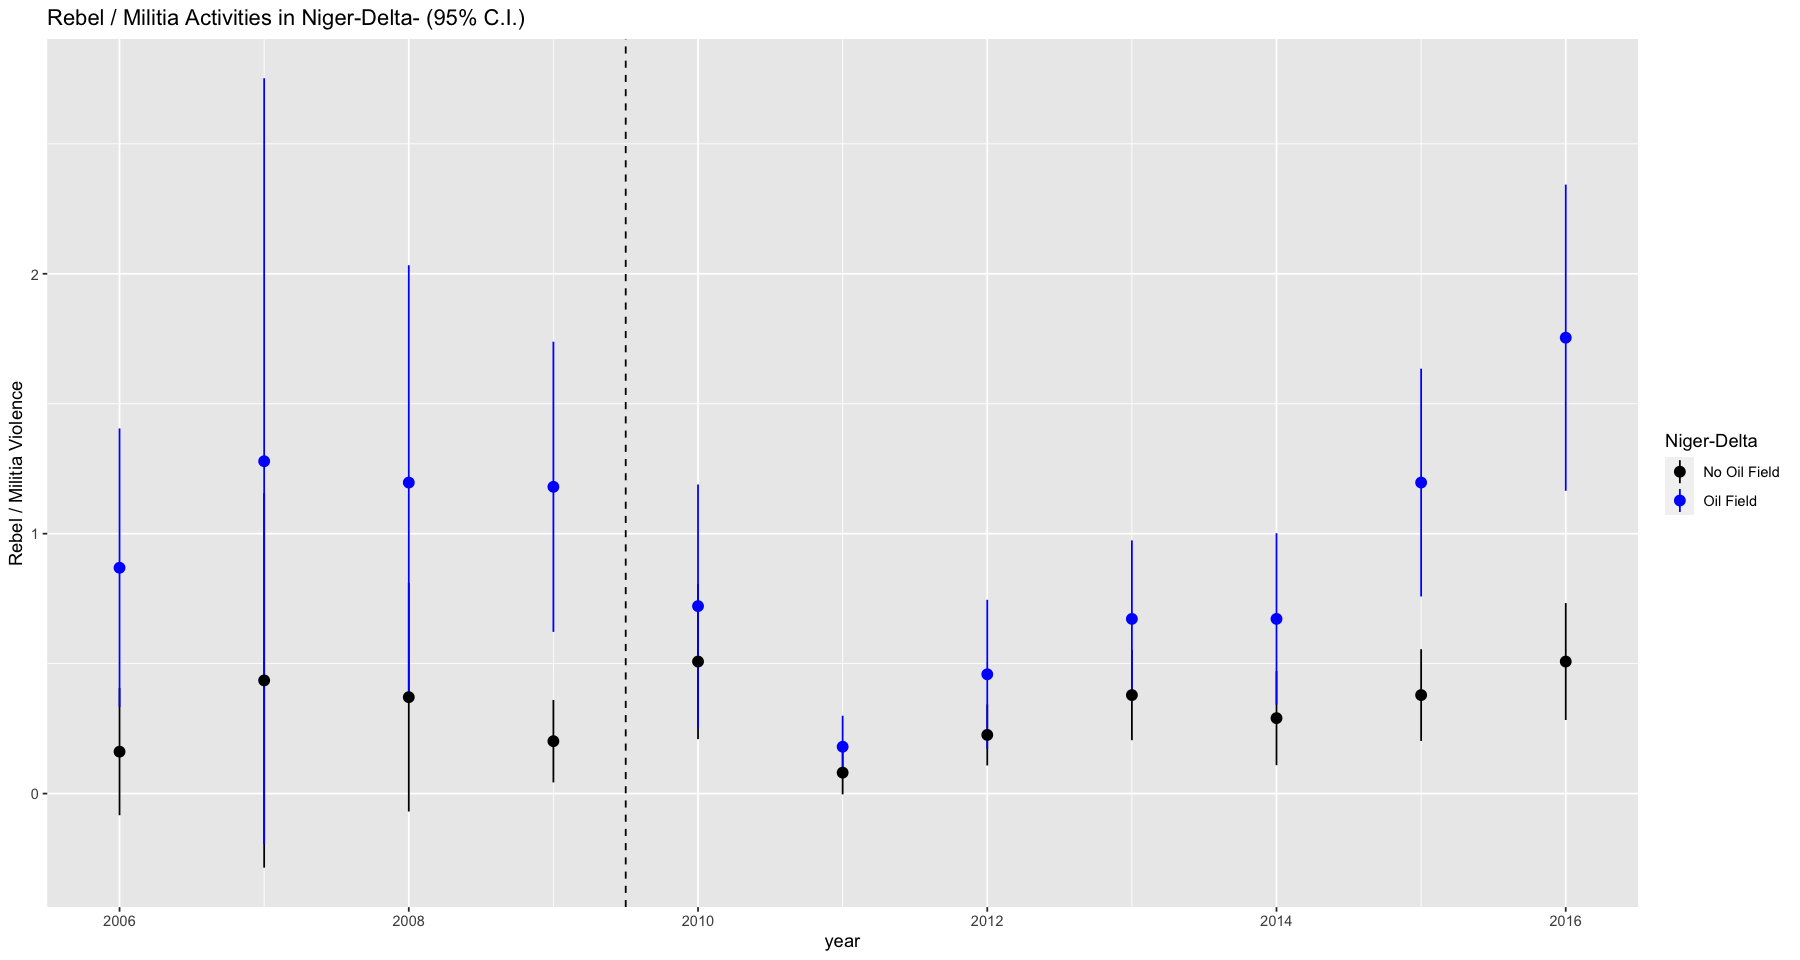

In [26]:
options(repr.plot.width = 15, repr.plot.height = 8)

ggplot(data = con_mean, aes(x = year, y = Rebel, group = niger_del_oilf, colour = niger_del_oilf)) +
  #geom_point(size = 4, alpha = .5) + # always plot the raw data
  stat_summary(fun.data = "mean_cl_normal") +
  labs(title = "Rebel / Militia Activities in Niger-Delta- (95% C.I.)")+
  geom_vline(xintercept = 2009.5, linetype = 2) +
  scale_color_manual(values = c('1' = 'blue', '0' = 'black'), labels = c("No Oil Field", "Oil Field"))+
  labs(y="Rebel / Militia Violence", colour = "Niger-Delta")

  What we see from the plot is that immediately after 2009 - when the policy was announced - the level of rebel and militia activities in LGAs oil fields reduces to the level of LGAs without oil fields. The plot gives the impression that the policy had an impact on violence in Niger-Delta with LGAs.  

# Regression Model  
The estimation strategy I will use is a difference-in-differences estimation strategy. For the difference-in-difference estimation to identify the effect of the amnesty policy on violence, it must be that Niger-Delta LGAs with and without oil fields must be on parallel trends before the amnesty policy. This implies that all factors that affect violence must fall into two categories - time invariant factors that are group specific and time changing factors that are group invariant. In this document I will not show how and why these assumptions hold in the research context, but in my thesis, I go through all the robustness checks.  

The regression model is as specified as - 

$$ Rebel_{lt}= \alpha_{l} +\delta_{t}  + \beta_{0} \boldsymbol{Policy_{t} \times Oil_{l}}+ \gamma_{l} t + \epsilon_{l} $$   
  
  The dependent variable is the occurrence of rebel and militia event in Niger-Delta LGA $l$, at time $t$. I include LGA and time fixed effect to control for unobserved heterogeneity across space and time. The main variable of interest is $\beta_{0}$ that is the interaction between a variable $policy$ - that picks up time period when the policy was active - and dummy $oil$ that indicate what LGAs in our dataset have oil fields.  
  
  To check that my regression model does not violate the main parallel trend assumption, I conduct an event type study. The event type study allows us to see how violence in LGAs with and without oil fields in the Niger-Delta changed over time. We are interested in how the change differed immediate before and after the amnesty policy was enacted. That is, was the difference in violence between both types of LGAs relatively stable before amnesty, and was there a huge change in the difference immediately after the amnesty policy was issued. The command below runs the event study estimation and plots the regression coefficient.

In [27]:
# Create dummy variables for every year (yr_200*) in the dataset

for (i in seq(2005, 2016)) {
  con_main[[paste0("yr_", i)]]<-0
  con_main[[paste0("yr_", i)]][con_main$year== i ]<-1
}

head(con_main[c("lgga", "year", "yr_2005", "yr_2006", "yr_2007", "yr_2008")])


,lgga,year,yr_2005,yr_2006,yr_2007,yr_2008
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,abadam,2005,1,0,0,0
2,abadam,2006,0,1,0,0
3,abadam,2007,0,0,1,0
4,abadam,2008,0,0,0,1
5,abadam,2009,0,0,0,0
6,abadam,2010,0,0,0,0


 Try using another color `palette` (and/or `package`).


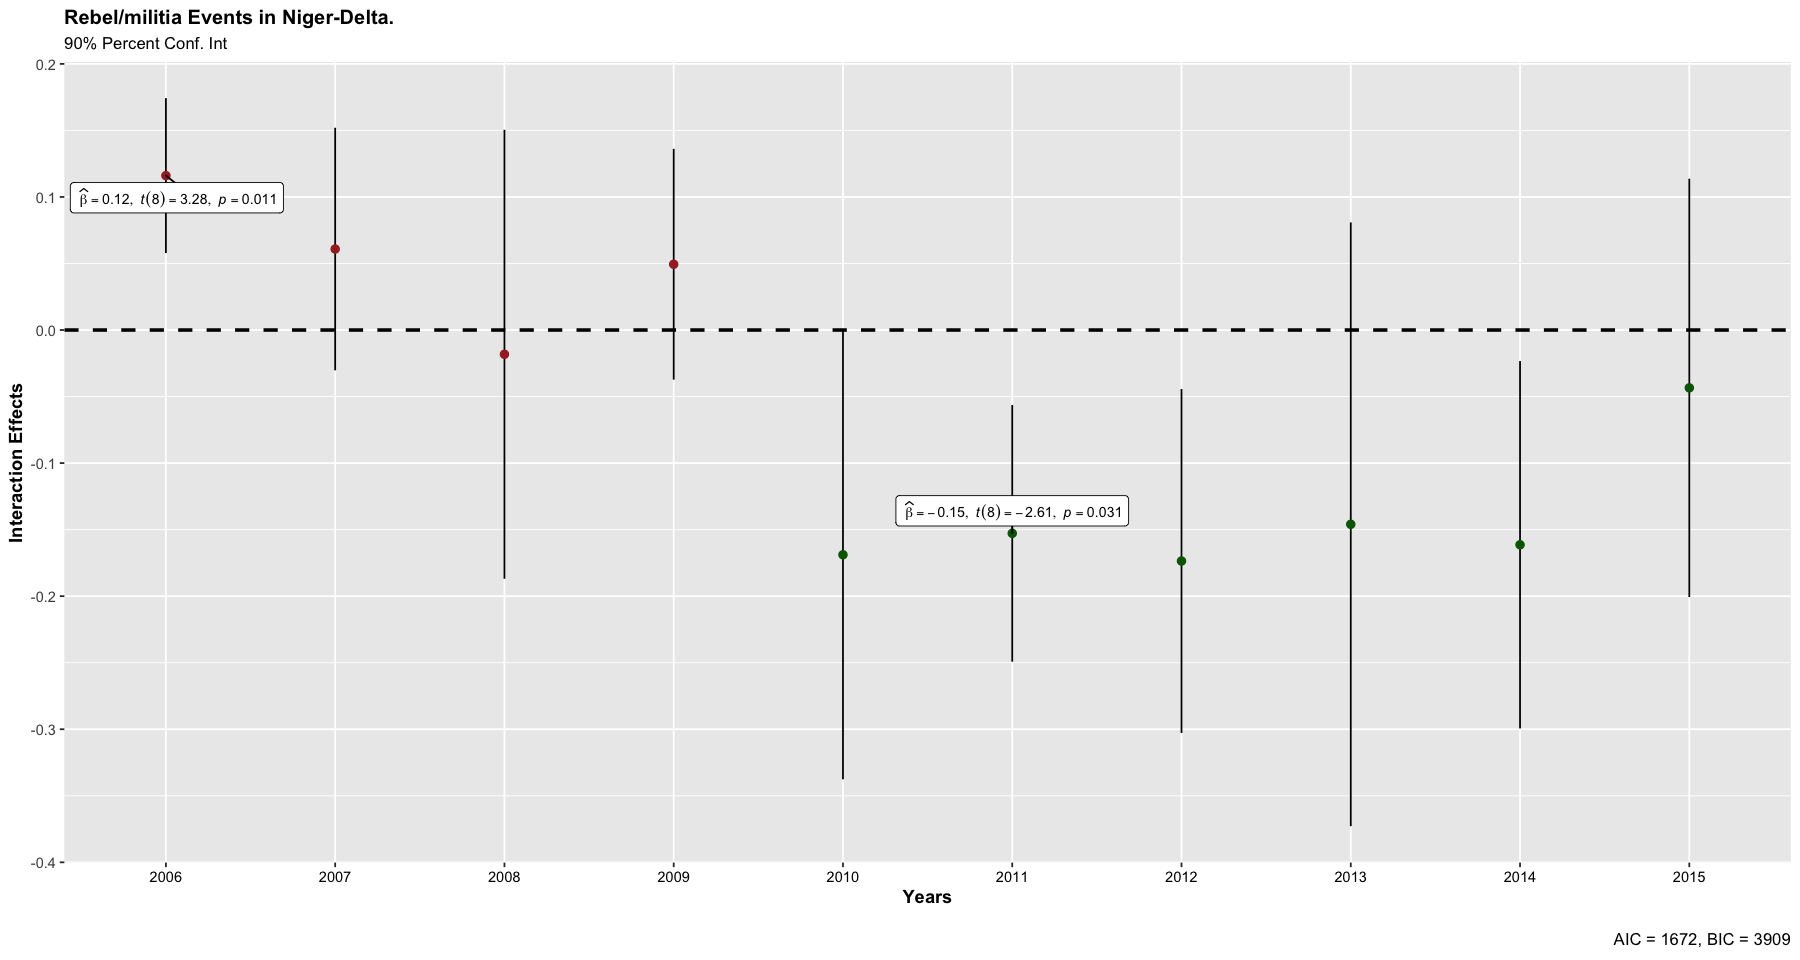

In [28]:
con_felm_yrs_loop<-list(length(con_main[, 13:19]))
# Event study regression including interaction of oil field with year dummies for all conflict types. 
for (i in seq_along(con_main[, 13:19])) {
  con_felm_yrs_loop[[i]]<-felm(con_main[, 13:19][[i]]~yr_2006:niger_del_oilf+
                                 yr_2007:niger_del_oilf+
                                 yr_2008:niger_del_oilf+
                                 yr_2009:niger_del_oilf+
                                 yr_2010:niger_del_oilf+
                                 yr_2011:niger_del_oilf+
                                 yr_2012:niger_del_oilf+
                                 yr_2013:niger_del_oilf+
                                 yr_2014:niger_del_oilf+
                                 yr_2015:niger_del_oilf
                               | year:as.factor(lgga) + as.factor(year) + as.factor(lgga)| 0 | state.x, 
                               data = con_main, subset = niger_del_all==1, exactDOF=TRUE, bootcluster= "model")
  
  names(con_felm_yrs_loop)[[i]]<-names(con_main[, 13:19])[[i]]
}

#Plot of the event study estimates.
ggcoefstats(con_felm_yrs_loop[[1]], only.significant = TRUE, 
            point.args = list(size = 2, color = c("brown", "brown", "brown","brown", "darkgreen", "darkgreen",
                                                  "darkgreen","darkgreen", "darkgreen", "darkgreen")),
            conf.level = 0.90,
            title = "Rebel/militia Events in Niger-Delta.",
            subtitle = "90% Percent Conf. Int",
            stats.labels = T,
            ggtheme = ggplot2::theme_gray()) +
  ggplot2::scale_y_discrete(labels = c("2006", "2007", "2008", "2009", "2010", "2011", "2012",
                                       "2013", "2014", "2015")) +
  ggplot2::labs(x="Interaction Effects", y="Years") +
  ggplot2::coord_flip()+
  theme(axis.text.x = element_text(color=c("black", "black", "black", "black", "black", 
                                   "black", "black", "black", "black", "black")))

  We see that the difference in the probability of violence is much higher in LGAs with oil field compared to LGAs without oil field relative to the base year of 2005 before the amnesty policy was enacted. We observe a sharp drop in the difference in probability of violence in LGAs with oil fields to LGAs without oil fields immediately after the amnesty policy was implemented. This provides evidence of a stable trend between types of LGAs before the amnesty policy and a sharp change in violence after the amnesty policy was implemented. Next, we look at average effects. 

  I create a list of dependent variable in my analysis. In addition to the probability of rebel activities, I also consider battles involving government forces, violence against civilians, protests and fatalities. Using the index of the desired dependent variables, I move the dependent variables into a list con_types. 

In [29]:
con_types<-con_main[c(13:19, 4)]
names(con_types)

[1] "prob_rebel"      "prob_Battles"    "prob_VAC"        "prob_event"     
[5] "prob_fatalities" "prob_protest"    "prob_Fata_rebel" "Fata_rebel"

  Next I use the lfe package to create a regression model that loops through the dependent variable and collects results. Standard errors are clustered at state-level. 

In [30]:
con_est_f<-list(length(con_types)) # Create a container for my regression results.

for (i in seq_along(con_types)) {
  con_est_f[[i]] <-felm(con_types[[i]]~niger_del_oilf:amnes_yr | year:as.factor(lgga) + as.factor(year) + as.factor(lgga) | 0 | state.x, data = con_main, subset = niger_del_all==1, exactDOF = TRUE, bootcluster = "model")
}

I display the regression results using the stargazer package. 

In [31]:
stargazer(con_est_f[[1]], con_est_f[[2]],con_est_f[[3]],con_est_f[[6]], con_est_f[[4]],con_est_f[[5]], type = "text" ,title = "Rebel and Militia Violence", 
          style = "aer", column.labels = c("Rebel", "Battles", "Civilian Violence", "Protest", "All Events", "Fatalities"), 
          covariate.labels = c("Policy Yr * Oil Field"), 
          dep.var.caption = c("Conflict Violence"),
          dep.var.labels.include = F, nobs = T, align = TRUE)



Rebel and Militia Violence
                                 Rebel   Battles  Civilian Violence Protest All Events Fatalities
                                  (1)      (2)           (3)          (4)      (5)        (6)    
-------------------------------------------------------------------------------------------------
Policy Yr * Oil Field           -0.273** -0.191**     -0.197**       0.033   -0.184*     -0.115  
                                (0.096)  (0.065)       (0.074)      (0.045)  (0.093)    (0.090)  
                                                                                                 
Observations                     2,220    2,220         2,220        2,220    2,220      2,220   
R2                               0.450    0.370         0.420        0.429    0.508      0.393   
Adjusted R2                      0.336    0.240         0.300        0.310    0.407      0.267   
Residual Std. Error (df = 1838)  0.326    0.267         0.284        0.247    0.339      0

  The results indicate that after the amnesty policy was enacted, the probability of an incidence rebel and militia LGAs with oil fields decreased by 34.9 percent. We also see that the probability of battles involving government forces reduced by 22.1 percent and violence against civilians decreased by 25.9 percent. However, the amnesty policy had no effect on protest and fatalities in the oil producing region in the Niger-Delta. 

In [32]:
con_event<- read.dta13("con_event2.dta")
head(con_event[c('state', 'year', 'lgga', 'log_rtotal', 'log_pop')])

,state,year,lgga,log_rtotal,log_pop
,<chr>,<dbl>,<chr>,<dbl>,<dbl>
1,Borno,2005,abadam,6.093570,11.50999
2,Borno,2006,abadam,5.804834,11.54826
3,Borno,2007,abadam,6.118097,11.58613
4,Borno,2008,abadam,6.039540,11.62363
5,Borno,2009,abadam,5.739150,11.66069
6,Borno,2010,abadam,6.068657,11.69743


In [33]:
con_main<-merge(con_main, con_event[c("year", 'lgga', 'log_rtotal', 'log_pop')], by=c("lgga", "year"), all.x = T)
head(con_main[c('lgga', 'year', 'log_rtotal', 'log_pop')])

,lgga,year,log_rtotal,log_pop
,<chr>,<dbl>,<dbl>,<dbl>
1,abadam,2005,6.093570,11.50999
2,abadam,2006,5.804834,11.54826
3,abadam,2007,6.118097,11.58613
4,abadam,2008,6.039540,11.62363
5,abadam,2009,5.739150,11.66069
6,abadam,2010,6.068657,11.69743


In [34]:
con_est_f<-list(length(con_types)) # Create a container for my regression results.

for (i in seq_along(con_types)) {
  con_est_f[[i]] <-felm(con_types[[i]]~niger_del_oilf:amnes_yr + log_rtotal + log_pop | year:as.factor(lgga) + as.factor(year) + as.factor(lgga) | 0 | state.x, data = con_main, subset = niger_del_all==1, exactDOF = TRUE, bootcluster = "model")
}

In [35]:

stargazer(con_est_f[[1]], con_est_f[[2]],con_est_f[[3]],con_est_f[[6]], con_est_f[[4]],con_est_f[[5]], type = "text" ,title = "Rebel and Militia Violence - Controlling for rainfall and population", 
          style = "aer", column.labels = c("Rebel", "Battles", "Civilian Violence", "Protest", "All Events", "Fatalities"), 
          covariate.labels = c("Rainfall (Log)", "Population (Log)","Policy Yr * Oil Field"), 
          dep.var.caption = c("Conflict Violence"),
          dep.var.labels.include = F, nobs = T, align = TRUE)



Rebel and Militia Violence - Controlling for rainfall and population
                                  Rebel    Battles  Civilian Violence   Protest   All Events Fatalities
                                   (1)       (2)           (3)            (4)        (5)        (6)    
-------------------------------------------------------------------------------------------------------
Rainfall (Log)                   -0.016    -0.066         0.055          0.094      0.010      0.038   
                                 (0.091)   (0.069)       (0.051)        (0.057)    (0.098)    (0.085)  
                                                                                                       
Population (Log)                -244.712   275.550      -683.798      -1,260.486* -629.509**  -109.979 
                                (402.948) (383.820)     (431.519)      (552.090)  (251.102)  (419.452) 
                                                                                                  

In [36]:
con_main$pol_00_13<-0
con_main$pol_00_13[con_main$year>2009 & con_main$year<2014]<-1

con_main$pol_14_16<-0
con_main$pol_14_16[con_main$year>2013]<-1

head(con_main[c('lgga', "year", "pol_00_13", "pol_14_16")], 12)

,lgga,year,pol_00_13,pol_14_16
,<chr>,<dbl>,<dbl>,<dbl>
1,abadam,2005,0,0
2,abadam,2006,0,0
3,abadam,2007,0,0
4,abadam,2008,0,0
5,abadam,2009,0,0
6,abadam,2010,1,0
7,abadam,2011,1,0
8,abadam,2012,1,0
9,abadam,2013,1,0


In [37]:
con_est_f<-list(length(con_types)) # Create a container for my regression results.

for (i in seq_along(con_types)) {
  con_est_f[[i]] <-felm(con_types[[i]]~niger_del_oilf:pol_00_13 + niger_del_oilf:pol_14_16 | year:as.factor(lgga) + as.factor(year) + as.factor(lgga) | 0 | state.x, data = con_main, subset = niger_del_all==1, exactDOF = TRUE, bootcluster = "model")
}

In [38]:
stargazer(con_est_f[[1]], con_est_f[[2]],con_est_f[[3]],con_est_f[[6]], con_est_f[[4]],con_est_f[[5]], type = "text" ,title = "Long run effect", 
          style = "aer", column.labels = c("Rebel", "Battles", "Civilian Violence", "Protest", "All Events", "Fatalities"), 
          covariate.labels = c('Policy(2010-13) * Oil Field', 'Policy(2014-16) * Oil Field'),
          dep.var.caption = c("Conflict Violence"),
          dep.var.labels.include = F, nobs = T, align = TRUE)


Long run effect
                                 Rebel   Battles  Civilian Violence Protest All Events Fatalities
                                  (1)      (2)           (3)          (4)      (5)        (6)    
-------------------------------------------------------------------------------------------------
Policy(2010-13) * Oil Field     -0.242** -0.222**     -0.158***      0.104    -0.129     -0.073  
                                (0.072)  (0.071)       (0.047)      (0.075)  (0.086)    (0.080)  
                                                                                                 
Policy(2014-16) * Oil Field      -0.180  -0.283**      -0.083        0.241    -0.024     0.009   
                                (0.125)  (0.102)       (0.103)      (0.149)  (0.130)    (0.111)  
                                                                                                 
Observations                     2,220    2,220         2,220        2,220    2,220      2,220   
R2 

In [39]:
con_est_f<-list(length(con_types)) # Create a container for my regression results.

for (i in seq_along(con_types)) {
  con_est_f[[i]] <-felm(con_types[[i]]~niger_del_oilf:amnes_yr + niger_del_oilf:yr_2009 | year:as.factor(lgga) + as.factor(year) + as.factor(lgga) | 0 | state.x, data = con_main, subset = niger_del_all==1, exactDOF = TRUE, bootcluster = "model")
}

In [40]:
stargazer(con_est_f[[1]], con_est_f[[2]],con_est_f[[3]],con_est_f[[6]], con_est_f[[4]],con_est_f[[5]], type = "text" ,title = "Placebo Effect", 
          style = "aer", column.labels = c("Rebel", "Battles", "Civilian Violence", "Protest", "All Events", "Fatalities"), 
          covariate.labels = c("Policy Yr * Oil Field", "Yr = 2009 * Oil Field"),
          dep.var.caption = c("Conflict Violence"),
          dep.var.labels.include = F, nobs = T, align = TRUE)


Placebo Effect
                                 Rebel   Battles  Civilian Violence Protest All Events Fatalities
                                  (1)      (2)           (3)          (4)      (5)        (6)    
-------------------------------------------------------------------------------------------------
Policy Yr * Oil Field           -0.295** -0.184**      -0.200*       0.010    -0.189     -0.158  
                                (0.104)  (0.073)       (0.096)      (0.045)  (0.102)    (0.124)  
                                                                                                 
Yr = 2009 * Oil Field            -0.042   0.013        -0.006       -0.046    -0.009     -0.084  
                                (0.034)  (0.027)       (0.070)      (0.041)  (0.055)    (0.069)  
                                                                                                 
Observations                     2,220    2,220         2,220        2,220    2,220      2,220   
R2  

In [41]:
con_main$pipe_near<-0
con_main$pipe_near[c(con_main$niger_del_all==1 & con_main$niger_del_oilf==0)]<-
  con_main$pipearea[c(con_main$niger_del_all==1 & con_main$niger_del_oilf==0)]
head(con_main[con_main$niger_del_all==1, c('lgga', 'niger_del_all', "niger_del_oilf", 'pipe_near')])

,lgga,niger_del_all,niger_del_oilf,pipe_near
,<chr>,<dbl>,<dbl>,<dbl>
25,abak,1,0,0
26,abak,1,0,0
27,abak,1,0,0
28,abak,1,0,0
29,abak,1,0,0
30,abak,1,0,0


In [42]:
con_est_f<-list(length(con_types)) # Create a container for my regression results.

for (i in seq_along(con_types)) {
  con_est_f[[i]] <-felm(con_types[[i]]~niger_del_oilf:amnes_yr + pipe_near:amnes_yr | year:as.factor(lgga) + as.factor(year) + as.factor(lgga) | 0 | state.x, data = con_main, subset = niger_del_all==1, exactDOF = TRUE, bootcluster = "model")
}

In [43]:
stargazer(con_est_f[[1]], con_est_f[[2]],con_est_f[[3]],con_est_f[[6]], con_est_f[[4]],con_est_f[[5]], type = "text" ,title = "Spill Over Effect", 
          style = "aer", column.labels = c("Rebel", "Battles", "Civilian Violence", "Protest", "All Events", "Fatalities"), 
          covariate.labels = c('Policy Yr * Oil Field', 'Policy Yr * Pipe Near'),
          dep.var.caption = c("Conflict Violence"),
          dep.var.labels.include = F, nobs = T, align = TRUE)


Spill Over Effect
                                 Rebel   Battles  Civilian Violence Protest All Events Fatalities
                                  (1)      (2)           (3)          (4)      (5)        (6)    
-------------------------------------------------------------------------------------------------
Policy Yr * Oil Field           -0.267** -0.197**     -0.183**       0.043   -0.184*     -0.118  
                                (0.099)  (0.065)       (0.079)      (0.042)  (0.094)    (0.088)  
                                                                                                 
Policy Yr * Pipe Near            0.251    -0.253       0.568*        0.393    0.002      -0.115  
                                (0.584)  (0.348)       (0.298)      (0.676)  (0.426)    (0.411)  
                                                                                                 
Observations                     2,220    2,220         2,220        2,220    2,220      2,220   
R

In [44]:
con_types<-con_main[c(10, 7, 8, 9, 6, 5)]
names(con_types)

[1] "Rebel"      "Battles"    "VAC"        "Protests"   "event"     
[6] "fatalities"

In [45]:
con_est_f<-list(length(con_types)) # Create a container for my regression results.

for (i in seq_along(con_types)) {
  con_est_f[[i]] <-felm(log(con_types[[i]]+1)~niger_del_oilf:amnes_yr | year:as.factor(lgga) + as.factor(year) + as.factor(lgga) | 0 | state.x, data = con_main, subset = niger_del_all==1, exactDOF = TRUE, bootcluster = "model")
}

In [46]:
stargazer(con_est_f[[1]], con_est_f[[2]],con_est_f[[3]],con_est_f[[4]], con_est_f[[5]],con_est_f[[6]], type = "text" ,title = "Intensity of Violence", 
          style = "aer", column.labels = c("Rebel", "Battles", "Civilian Violence", "Protest", "All Events", "Fatalities"), 
          covariate.labels = c('Policy Yr * Oil Field'),
          dep.var.caption = c("Conflict Violence"),
          dep.var.labels.include = F, nobs = T, align = TRUE)


Intensity of Violence
                                  Rebel   Battles  Civilian Violence Protest All Events Fatalities
                                   (1)      (2)           (3)          (4)      (5)        (6)    
--------------------------------------------------------------------------------------------------
Policy Yr * Oil Field           -0.429*** -0.212**     -0.232**       0.058   -0.377**    -0.165  
                                 (0.118)  (0.080)       (0.080)      (0.036)  (0.127)    (0.183)  
                                                                                                  
Observations                      2,220    2,220         2,220        2,220    2,220      2,220   
R2                                0.565    0.425         0.509        0.623    0.668      0.401   
Adjusted R2                       0.475    0.306         0.407        0.544    0.599      0.277   
Residual Std. Error (df = 1838)   0.345    0.258         0.274        0.265    0.400  

# Conclusion
The Niger-Delta amnesty program was implemented in 2010 to reduce the violence in the oil producing region of Nigeria. The estimation in this research quantifies the effect of the amnesty policy on violence in the Niger-Delta. We see that the amnesty policy reduced incidence of rebel and militia activities, battles involving governemnt forces and violent against civilians. However, the policy as expected had no effect on non-violent protest in the Niger-Delta.  

# The End




